In [1]:
import pandas as pd
import numpy as np
import random
import fastai
from fastai.text import *
from fastai.callbacks import *
torch.cuda.set_device(0)

### Create sample dataset

In [2]:
# df = pd.read_pickle("pickle/master_frame.pkl")
# df_trimmed = df[["title", 'abstract', 'chemicals']].dropna()
# df_trimmed.to_pickle("pickle/master_frame_trimmed.pkl")

# df_trimmed = pd.read_pickle("pickle/master_frame_trimmed.pkl")
# df_sample_10000 = df_trimmed.sample(n=10000, random_state=1)
# df_sample_10000.to_pickle("pickle/master_frame_sample_10000.pkl")

# df_trimmed = pd.read_pickle("pickle/master_frame_trimmed.pkl")
# df_sample_20000 = df_trimmed.sample(n=20000, random_state=1)
# df_sample_20000.to_pickle("pickle/master_frame_sample_20000.pkl")

# df_trimmed = pd.read_pickle("pickle/master_frame_trimmed.pkl")
# df_sample_50000 = df_trimmed.sample(n=50000, random_state=1)
# df_sample_50000.to_pickle("pickle/master_frame_sample_50000.pkl")

# df_trimmed = pd.read_pickle("pickle/master_frame_trimmed.pkl")
# df_sample_100000 = df_trimmed.sample(n=100000, random_state=1)
# df_sample_100000.to_pickle("pickle/master_frame_sample_100000.pkl")

### Create FastAI data bunch

In [3]:
def create_data_bunches(num_samples, split):
    # Create Language Model DataBunch
    print(f"Creating Language Model DataBunch - (Samples : {num_samples})")
    version = f"sample_{num_samples}"
    df_sample = pd.read_pickle(f"pickle/master_frame_{version}.pkl")

    X = df_sample[:int(len(df_sample)*split)]
    y = df_sample[int(len(df_sample)*(1-split)):]

    data_lm = TextLMDataBunch.from_df(path="fastai", train_df=X, valid_df=y)

    data_lm.save(f'../pickle/data_lm_{version}.pkl')
    
    # Create Classification DataBunch
    print(f"Creating Classification DataBunch - (Samples : {num_samples})")
    df_sample.drop("title", axis=1, inplace=True)
    df_sample.columns = ['text', 'target']
    df_sample = df_sample[['target', 'text']]

    X = df_sample[:int(len(df_sample)*split)]
    y = df_sample[int(len(df_sample)*(1-split)):]

    data_clas = TextClasDataBunch.from_df(path="fastai", train_df=X, valid_df=y, vocab=data_lm.vocab)
    data_clas.save(f'../pickle/data_clas_{version}.pkl')

In [4]:
# all_samples = [10000, 20000, 50000, 100000]
# for samples in all_samples:
#     create_data_bunches(samples, 0.5)

### Train Language Model

In [5]:
def get_rand_params(params):
    rand_params = {}
    for name, param in params.items():
        if type(param) == list:
            rand_params.update({name : int(np.random.choice(param))})
        elif type(param) == tuple:
            rand_params.update({name : float(random.uniform(param[0], param[1]))})
        else:
            rand_params.update({name : param})
    return rand_params

def get_min_grad(model):
    model.lr_find(num_it=200)
    model.recorder.plot(suggestion=True)
    return model.recorder.min_grad_lr

def train_lm_model(bs, drop_mult, epochs, num_samples):
    # Load data
    version = f"sample_{num_samples}.pkl"
    data_lm = load_data("pickle", f'data_lm_{version}', bs=bs)

    # Define metrics
    metrics = [accuracy]

    # Define model callbacks
    early_stop = partial(EarlyStoppingCallback,
                         monitor='accuracy',
                         mode="max",
                         min_delta=0.01,
                         patience=5)
    graph = ShowGraph
    callback_fns = [early_stop]#, graph]

    # Define language model
    learn_lm = language_model_learner(data_lm,
                                      AWD_LSTM,
                                      drop_mult=drop_mult,
                                      metrics=metrics,
                                      callback_fns=callback_fns).to_fp16()
    
    # Define training callback
    model_name = f"learn_lm_{version}_bs_{bs}_dropmult_{drop_mult}"
    model_enc_name = f"learn_lm_enc_{version}_bs_{bs}_dropmult_{drop_mult}"
    save_best = SaveModelCallback(learn_lm,
                                  every='improvement',
                                  monitor="accuracy",
                                  mode="max",
                                  name=model_name)
    callbacks = [save_best]

    # Train
    min_grad = get_min_grad(learn_lm)
    learn_lm.fit_one_cycle(1, min_grad, callbacks=callbacks)
    learn_lm.unfreeze()

    min_grad = get_min_grad(learn_lm)
    learn_lm.fit_one_cycle(epochs, slice(min_grad,min_grad*100), moms=(0.8,0.7), callbacks=callbacks)
    
    # Get accuracy
    best_acc = max([i[0] for i in learn_lm.recorder.metrics]).item()
    
    # Load best model
    learn_lm.load(model_name)
    
    # Save encoding
    learn_lm.save_encoder(model_enc_name)
    
    return (best_acc, model_name, model_enc_name, learn_lm, data_lm)

def hyper_param_lm_search(num_runs, params):
    param_log = []
    run_log = []
    
    for i in range(num_runs):
        print(f"RUN {i + 1} of {num_runs}")
        rand_params = get_rand_params(params)
        param_log.append(rand_params)
        run_result = train_lm_model(**rand_params)
        run_log.append(run_result)
        
    best_run = np.argmax([i[0] for i in run_log])
        
    return (param_log[best_run], run_log[best_run])

In [6]:
# params = {"bs" : 64,
#           "drop_mult" : 0.5,
#           "epochs" : 10,
#           "num_samples" : 10000}

In [7]:
params = {"bs" : [32, 64, 128],
          "drop_mult" : (0.2, 0.7),
          "epochs" : 1,
          "num_samples" : 50000}

In [15]:
tuple([3,4])

(3, 4)

In [8]:
import json

In [13]:
with open("artifacts/test.json", "w+") as f:
    f.write(json.dumps(params))

RUN 1 of 3


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-07
Min loss divided by 10: 8.32E-03


epoch,train_loss,valid_loss,accuracy,time
0,5.381798,5.130618,0.268420,01:29


Better model found at epoch 0 with accuracy value: 0.26841992139816284.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-03
Min loss divided by 10: 2.51E-03


epoch,train_loss,valid_loss,accuracy,time
0,7.610916,6.379268,0.308536,01:34


Better model found at epoch 0 with accuracy value: 0.3085363507270813.
RUN 2 of 3


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-07
Min loss divided by 10: 5.75E-03


epoch,train_loss,valid_loss,accuracy,time
0,5.452284,5.128658,0.268604,02:19


Better model found at epoch 0 with accuracy value: 0.26860424876213074.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-07
Min loss divided by 10: 1.91E-03


epoch,train_loss,valid_loss,accuracy,time
0,5.181184,4.931152,0.283942,02:34


Better model found at epoch 0 with accuracy value: 0.28394219279289246.
RUN 3 of 3


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 1.00E-02


epoch,train_loss,valid_loss,accuracy,time
0,4.622078,4.118785,0.318197,01:30


Better model found at epoch 0 with accuracy value: 0.3181968331336975.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-07
Min loss divided by 10: 4.79E-04


epoch,train_loss,valid_loss,accuracy,time
0,4.196192,4.131843,0.317776,01:34


Better model found at epoch 0 with accuracy value: 0.31777575612068176.


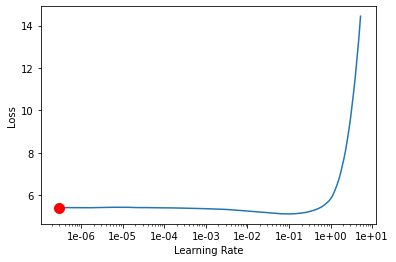

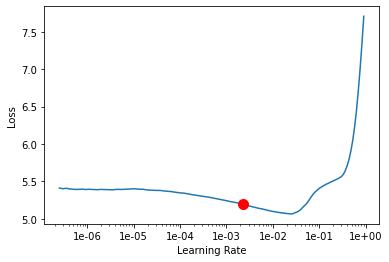

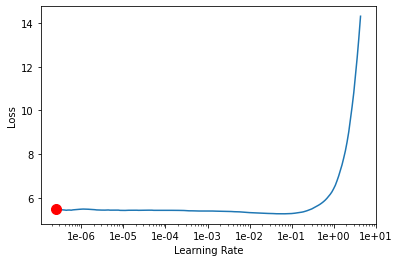

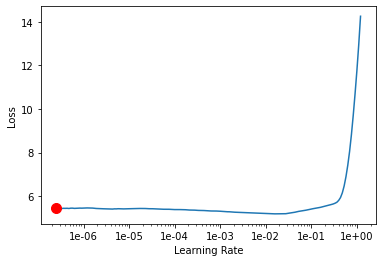

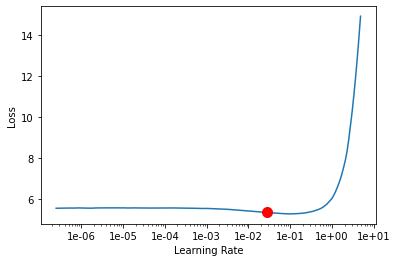

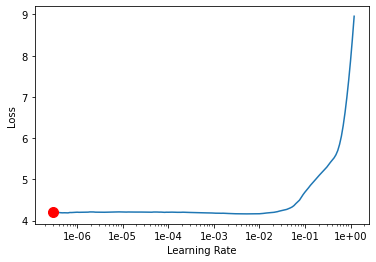

In [8]:
best_params, best_run = hyper_param_lm_search(3, params)

In [9]:
best_run[0]

0.31777575612068176

In [10]:
best_params

{'bs': 128, 'drop_mult': 0.6450787380744305, 'epochs': 1, 'num_samples': 50000}

In [12]:
best_params["epochs"] = 10

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-07
Min loss divided by 10: 1.00E-02


epoch,train_loss,valid_loss,accuracy,time
0,5.541803,5.130800,0.268399,01:30


Better model found at epoch 0 with accuracy value: 0.2683994770050049.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-03
Min loss divided by 10: 3.31E-03


epoch,train_loss,valid_loss,accuracy,time
0,6.791133,6.312819,0.261393,01:34
1,6.225722,5.606315,0.246016,01:34
2,5.852060,5.574659,0.266828,01:34
3,5.229268,4.921249,0.283011,01:33
4,5.047976,4.815795,0.288526,01:35
5,4.729555,4.497596,0.304254,01:34
6,4.544194,4.334995,0.314074,01:34
7,4.251309,4.106198,0.325877,01:34
8,3.941383,3.918527,0.338088,01:34
9,3.697198,3.880655,0.341121,01:35


Better model found at epoch 0 with accuracy value: 0.26139312982559204.
Better model found at epoch 2 with accuracy value: 0.2668275833129883.
Better model found at epoch 3 with accuracy value: 0.283011257648468.
Better model found at epoch 4 with accuracy value: 0.28852614760398865.
Better model found at epoch 5 with accuracy value: 0.30425429344177246.
Better model found at epoch 6 with accuracy value: 0.31407439708709717.
Better model found at epoch 7 with accuracy value: 0.32587748765945435.
Better model found at epoch 8 with accuracy value: 0.33808764815330505.
Better model found at epoch 9 with accuracy value: 0.34112071990966797.


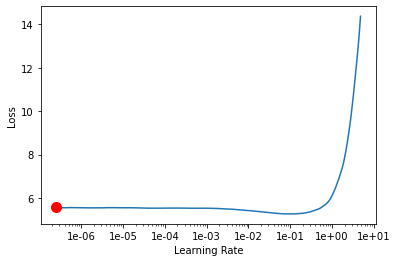

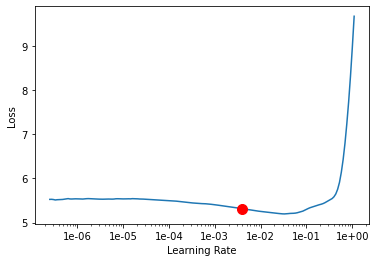

In [13]:
best_acc, model_name, model_enc_name, learn_lm, data_lm = train_lm_model(**best_params)

### Language Model Predictions

In [50]:
data_lm = load_data("", "/User/nlp/run/data_lm.pkl", bs=64)

/conda/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [51]:
learn_lm = language_model_learner(data_lm, AWD_LSTM)

In [52]:
learn_lm.load("/User/nlp/run/train_lm_model")
learn_lm.freeze()

In [55]:
learn_lm.predict("The aim of this study was to", n_words=100, temperature=0.5)

"The aim of this study was to determine the prevalence of Parkinson 's disease ( PD ) in the PD - PD ( PD ) model . In this study , we examined the effects of PD on the effects of PD on the biological activity of the PD - PD in the PD - PD . The study was designed to investigate the role of the Pd - Pd - Pd in the progression of PD - PD - PD in the Pd - PD"

In [58]:
learn_lm.predict("The disease has mutated and", n_words=100, temperature=0.5)

'The disease has mutated and recently been investigated in human breast cancer patients . The aim of this study was to investigate the effects of the HPV on DNA damage in the human HPV - associated cancer cell line . The HPV DNA - infected HPV - DNA - DNA polymerase chain reaction ( PCR ) showed that the HPV - associated HPV gene was associated with a tumor suppressor gene and a p53 mutation in the HPV / HPV gene in the HPV . The HPV'

In [63]:
learn_lm.predict("In the course of our diagnostics, we found", n_words=100, temperature=0.7)

'In the course of our diagnostics, we found that the interactions of the human serum albumin and serum albumin levels were strongly influenced by the DNA - bound DNA . The interaction between DNA and DNA was examined by measuring the activity of the DNA chain and the presence of the DNA DNA base at the surface of the DNA of the DNA of the two drugs . This study revealed that the DNA and the DNA of the two sites could be used to produce a hot spot that was located on the detached'

In [32]:
import dill

In [35]:
test = learn_lm.save("/User/nlp/run/test")

### Define Classification Model

In [30]:
def get_rand_params(params):
    rand_params = {}
    for name, param in params.items():
        if type(param) == list:
            rand_params.update({name : int(np.random.choice(param))})
        elif type(param) == tuple:
            rand_params.update({name : float(random.uniform(param[0], param[1]))})
        else:
            rand_params.update({name : param})
    return rand_params

def get_min_grad(model):
    model.lr_find(num_it=200)
    model.recorder.plot(suggestion=True)
    return model.recorder.min_grad_lr

def train_clas_model(bs, thresh, drop_mult, epochs, num_samples, encodings):
    # Load data
    version = f"sample_{num_samples}.pkl"
#     data_clas = load_data("pickle", f'data_clas_{version}', bs=bs)
    data_clas = load_data("", "/User/nlp/run/data_clas.pkl", bs=bs)

    # Define metrics
    acc = partial(accuracy_thresh, thresh=thresh)
    f_score = partial(fbeta, thresh=thresh)
    metrics = [acc, f_score]

    # Define model callbacks
    early_stop = partial(EarlyStoppingCallback,
                         monitor='fbeta',
                         mode="max",
                         min_delta=0.001,
                         patience=5)
    graph = ShowGraph
    callback_fns = [early_stop]#, graph]

    # Define classification model
    learn_clas = text_classifier_learner(data_clas,
                                         AWD_LSTM,
                                         drop_mult=drop_mult,
                                         metrics=metrics,
                                         callback_fns=callback_fns).to_fp16()
    learn_clas.load_encoder(encodings)
    learn_clas.freeze()
    
    # Define training callback
    model_name = f"learn_clas_{version}_bs_{bs}_thresh_{thresh}_dropmult_{drop_mult}"
    save_best = SaveModelCallback(learn_clas,
                                  every='improvement',
                                  monitor="fbeta",
                                  mode="max",
                                  name=model_name)
    callbacks = [save_best]

    # Train
    min_grad = get_min_grad(learn_clas)
    learn_clas.fit_one_cycle(1, min_grad, callbacks=callbacks)
    learn_clas.unfreeze()

    min_grad = get_min_grad(learn_clas)
    learn_clas.fit_one_cycle(epochs, slice(min_grad,min_grad*100), moms=(0.8,0.7), callbacks=callbacks)
    
    # Get f score
    best_fbeta = max([i[1] for i in learn_clas.recorder.metrics]).item()
    
    return (best_fbeta, model_name, learn_clas, data_clas)

def hyper_param_clas_search(num_runs, params):
    param_log = []
    run_log = []
    
    for i in range(num_runs):
        print(f"RUN {i + 1} of {num_runs}")
        rand_params = get_rand_params(params)
        param_log.append(rand_params)
        run_result = train_clas_model(**rand_params)
        run_log.append(run_result)
        
    best_run = np.argmax([i[0] for i in run_log])
        
    return (param_log[best_run], run_log[best_run])

### Train Classification Model

In [31]:
# params = {"bs" : 64,
#           "thresh" : 0.05,
#           "drop_mult" : 0.5,
#           "epochs" : 10,
#           "num_samples" : 10000,
#           "encodings" : "learn_lm_enc_sample_10000.pkl_bs_64_dropmult_0.5"}

In [32]:
# best_fbeta, model_name, learn_clas, data_clas = train_clas_model(**params)

### Hyperparameter Tuning

In [33]:
# learn_lm_enc_sample_10000.pkl_bs_64_dropmult_0.5
# learn_lm_enc_sample_10000.pkl_bs_32_dropmult_0.22643023822787633
# learn_lm_enc_sample_50000.pkl_bs_128_dropmult_0.6450787380744305

In [98]:
# encodings = "/User/nlp/pickle/models/learn_lm_enc_sample_10000.pkl_bs_128_dropmult_0.6630502684670632"
encodings = "/User/nlp/run/train_lm_model_enc.pkl"

In [99]:
params = {"bs" : [32, 64, 128],
          "thresh" : (0.01, 0.1),
          "drop_mult" : (0.2, 0.7),
          "epochs" : 1,
          "num_samples" : 10000,
          "encodings" : encodings}

In [39]:
data_clas = load_data("", "/User/nlp/run/data_clas.pkl", bs=32)
# data_clas = load_data("", "/User/nlp/pickle/data_clas_sample_10000.pkl", bs=32)

/conda/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.loss.BCEWithLogitsLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [101]:
acc = partial(accuracy_thresh, thresh=0.01)
f_score = partial(fbeta, thresh=0.01)
metrics = [acc, f_score]

# Define model callbacks
early_stop = partial(EarlyStoppingCallback,
                     monitor='fbeta',
                     mode="max",
                     min_delta=0.001,
                     patience=5)
graph = ShowGraph
callback_fns = [early_stop]#, graph]

# Define classification model
learn_clas = text_classifier_learner(data_clas,
                                     AWD_LSTM,
                                     drop_mult=0.5,
                                     metrics=metrics,
                                     callback_fns=callback_fns).to_fp16()
learn_clas.load_encoder(encodings)
learn_clas.freeze()

In [40]:
learn_clas = text_classifier_learner(data_clas, AWD_LSTM)

In [42]:
learn_clas.load("/User/nlp/run/train_clas_model")
learn_clas.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-02
Min loss divided by 10: 3.02E-01


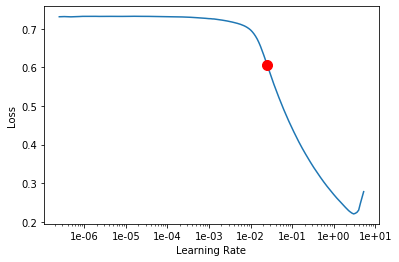

In [102]:
min_grad = get_min_grad(learn_clas)

In [103]:
min_grad

0.02511886431509582

In [104]:
learn_clas.fit_one_cycle(1, min_grad)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.030081,0.004160,0.996246,0.038818,00:16


In [37]:
data_clas

TextClasDataBunch;

Train: LabelList (5000 items)
x: TextList
xxbos xxmaj the urinary bladder wall is lined by a layer of mucus which is believed to provide an important barrier to bacterial invasion of the urinary tract . xxmaj abnormal function of this protective layer could therefore be a factor predisposing the host to urinary tract infection ( xxup uti ) . xxmaj this study investigated the contribution of the bladder mucus to host defence in both acute and chronic lower xxup uti , using a non - obstructive animal model of infection which xxunk many features of the disease in man . xxmaj the ultrastructural appearance of the infected bladder mucosa was assessed in tissue in which both the layer of mucus and bacterial xxunk were stabilized prior to examination by scanning and transmission electron microscopy . xxmaj the protective role of the mucus layer was determined by disrupting the layer immediately prior to bacterial challenge . xxmaj both ultrastructural and bacteriological a

In [35]:
best_params, best_run = hyper_param_clas_search(3, params)

In [25]:
best_params

{'bs': 32,
 'thresh': 0.09172097400650732,
 'drop_mult': 0.5874018194987243,
 'epochs': 1,
 'num_samples': 50000,
 'encodings': 'learn_lm_enc_sample_50000.pkl_bs_128_dropmult_0.6450787380744305'}

In [26]:
best_run[0]

0.027751296758651733

In [27]:
best_params["epochs"] = 10

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-02
Min loss divided by 10: 4.79E-01


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.001928,0.001696,0.999724,0.040357,01:06


Better model found at epoch 0 with fbeta value: 0.04035665839910507.


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-07
Min loss divided by 10: 2.51E-04


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.001924,0.001703,0.999735,0.035190,01:48
1,0.001924,0.001712,0.999710,0.046403,01:46
2,nan,nan,0.999758,0.000000,01:56
3,nan,nan,0.999758,0.000000,01:52
4,nan,nan,0.999758,0.000000,01:57
5,nan,nan,0.999758,0.000000,01:52
6,nan,nan,0.999758,0.000000,01:58


Better model found at epoch 0 with fbeta value: 0.035189878195524216.
Better model found at epoch 1 with fbeta value: 0.04640305042266846.
Epoch 7: early stopping


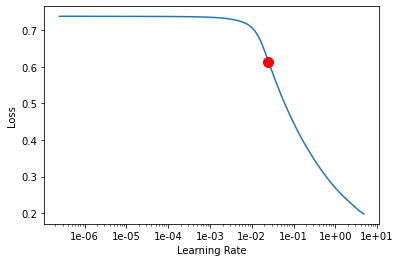

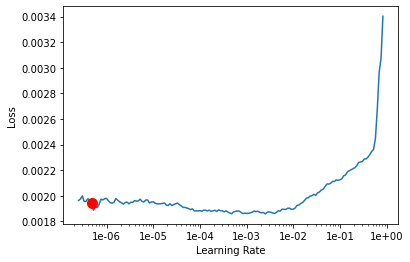

In [28]:
best_fbeta, model_name, learn_clas, data_clas = train_clas_model(**best_params)

In [47]:
text = 'The effect of prenatal alcohol exposure on nerve cell development was investigated in neurons and glial cells cultured from fetal rat brain. Neurons were grown for one week from two week-old cortical brain cells and glial cells were cultured during four weeks from new born cortical brain cells. Two situations were examined: maternal alcohol treatment before and during pregnancy and alcohol exposure only until the beginning of pregnancy. In both situations we found a delayed nerve cell maturation assessed by biochemical markers like enolase and glutamine synthetase. Alterations of lactate dehydrogenase activity and reduced superoxide dismutase activity, involved in free radicals elimination were also observed. "In vitro" addition of alcohol to the culture medium produced an additional effect showing a lower response in the prenatal alcohol exposed brain cells than in the controls. The results confirm our previous "in vivo" experiments showing long lasting effects of maternal alcohol exposure in the offspring.'

preds = """
        Ethanol
        L-Lactate Dehydrogenase
        Biomarkers
        Superoxide Dismutase
        Aspartate Aminotransferases
        """

In [43]:
text = "Intrarenal interleukin-15 (IL-15) plays a major role controlling epithelial survival and polarization both in physiological and pathologic conditions. Herein, we confirmed that human renal cell carcinomas (RCCs) express a membrane-bound IL-15 isoform displaying an unusual molecular weight of 27 kDa. Its stimulation with soluble IL-15 receptor α chain (s-IL-15Rα) triggers epithelial-mesenchymal transition (EMT) process as shown by the down-regulation of E-cadherin and zona occludens 1 and the up-regulation of vimentin and N-cadherin and promotes the migratory and invasive properties of RCC. S-IL-15Rα treatment triggered the Src/PI3K/Akt/GSK-3β pathway and promoted β-catenin nuclei translocation. Deactivation of this pathway by using Src-specific inhibitor PP2, PI3K inhibitor LY294002, and AKT inhibitor MK2206 hampered β-catenin nuclei translocation and suppressed EMT, migration, and invasion of RCC. S-IL-15Rα treatment also enhanced Src-dependent phosphorylation of focal adhesion kinase (FAK) and extracellular signal-regulated kinase (Erk1/2). FAK knockdown significantly decreased the migration and invasion of RCC, which suggest that Src-FAK signaling was involved in s-IL-15Rα-favored migration and invasion of RCC. At the same time, inhibitors of Erk1/2 also significantly decreased the migration and invasion of RCC but could not reverse s-IL-15Rα-induced EMT. Taken together, our results reveal that Src-dependent PI3K/Akt/GSK3b/β-catenin pathway is required for s-IL-15Ra-dependent induction of EMT in RCC, while Src-FAK and Src-Erk1/2 signaling were involved in s-IL-15Rα-promoted migration and invasion properties of RCC. Our study provides a better understanding of IL-15 signaling in RCC tumor progression, which may lead to novel targeted therapies and provide some suggestions when using IL-15 in clinic. "

In [43]:
# preds,targs = learn_clas.get_preds()

In [48]:
# pred = learn_clas.predict(text, thresh=0.05)
pred = learn_clas.predict(text)

In [45]:
max(pred[2])

tensor(0.2616)

In [48]:
print(sum(pred[1]))
pred[0].obj

tensor(0.)


[]

In [49]:
idxs = []
preds = list(np.argsort(pred[2]))[::-1]
for p in preds[:5]:
    idxs.append(p.item())
for idx in idxs:
    print(data_clas.classes[idx])

Dopamine
RNA, Messenger
Insulin
Estradiol
Biomarkers


In [240]:
df_sample = pd.read_pickle("pickle/master_frame_sample_10000.pkl")

In [244]:
np.random.choice(np.array(df_sample["abstract"].to_list()))

'Intrarenal interleukin-15 (IL-15) plays a major role controlling epithelial survival and polarization both in physiological and pathologic conditions. Herein, we confirmed that human renal cell carcinomas (RCCs) express a membrane-bound IL-15 isoform displaying an unusual molecular weight of 27 kDa. Its stimulation with soluble IL-15 receptor α chain (s-IL-15Rα) triggers epithelial-mesenchymal transition (EMT) process as shown by the down-regulation of E-cadherin and zona occludens 1 and the up-regulation of vimentin and N-cadherin and promotes the migratory and invasive properties of RCC. S-IL-15Rα treatment triggered the Src/PI3K/Akt/GSK-3β pathway and promoted β-catenin nuclei translocation. Deactivation of this pathway by using Src-specific inhibitor PP2, PI3K inhibitor LY294002, and AKT inhibitor MK2206 hampered β-catenin nuclei translocation and suppressed EMT, migration, and invasion of RCC. S-IL-15Rα treatment also enhanced Src-dependent phosphorylation of focal adhesion kinas